## Feature classification in tensorflow/keras with a simple MLP  

This notebook demonstrates how to perform a basic feature classification example with a Multi layer perceptron (MLP) using tensorflow/keras.

Although this classification task is very simple, it will serve as a basic demonstration of a typical workflow in tensorflow/keras. 


![](_images/class_bound.png)





In [1]:
!which jupyterlab

/bin/bash: /opt/conda/envs/dl-mw-py39/lib/libtinfo.so.6: no version information available (required by /bin/bash)


In [1]:
!pip install matplotlib

/bin/bash: /opt/conda/envs/dl-mw-py39/lib/libtinfo.so.6: no version information available (required by /bin/bash)


In [2]:
!pip install keras

/bin/bash: /opt/conda/envs/dl-mw-py39/lib/libtinfo.so.6: no version information available (required by /bin/bash)


In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import tensorflow as tf

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback, ReduceLROnPlateau

cmap = 'coolwarm'
colors = np.array(tuple(plt.cm.get_cmap(cmap)(float(v)) for v in (0,1)))

## Data


Lets first define the Dataset for which we use some demo data from `scikit-learn` that provides some datasets of  points having 2 features:

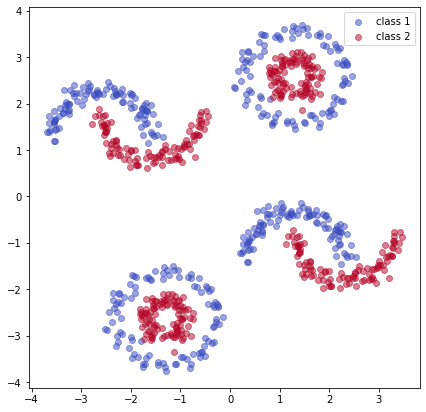

In [4]:
from sklearn import datasets

XA, YA = datasets.make_moons(n_samples=200, noise=0.1)
XB, YB = datasets.make_circles(n_samples=200,noise=.1, factor=.4)

off = 1.3
X = np.concatenate([XA+off*np.array([-2,1]),XB+off*np.array([1,2]), XA+off*np.array([1,-1]),XB+off*np.array([-1,-2])], axis=0)
Y = np.concatenate([YA,YB, YA, YB], axis=0)

plt.figure(figsize=(7,7))
for i in (0,1): 
    plt.scatter(*X[Y==i].T, color = colors[i], marker='o', alpha=.5, label = f'class {i+1}')
plt.legend()
plt.show()

Note that the shape of the input data `X` is `(number_of_samples, 2)` (with the feature dimension `2`) and that of the target `Y` is simple `(number_of_samples, 1)` containing the class number as an integer. 

In general for tensorflow, the input/output data has to have the shape `(N, ... , C)` with the first dimension being the batch/sample dimension `N` and the last dimension being the channel dimension `C`. If you later segment images or volumes, they would have to have dimensions `(N, Height, Width, C)` (2D images) or   `(N, Depth, Height, Width, C)` (volumes), with the channel dimension always being last. Note that this is different in `pytorch`, where the channel dimension is the second dimension.

| Data | `tensorflow` | `pytorch` |
| --- | --- | --- |
| pure features | `(N,C)` | `(N,C)` |
| images (2D) | `(N,H,W,C)` | `(N,C,H,W)` |
| volumes (3D) | `(N,D,H,W,C)` | `(N,C,D,H,W)` |



In [5]:
print(f"{X.shape=}, {Y.shape=}")
print(f"first input element: {X[0]=} with class label {Y[0]=}")

X.shape=(800, 2), Y.shape=(800,)
first input element: X[0]=array([-3.64697225,  1.72597869]) with class label Y[0]=0


Lets split our data into training data (which will be used for optimizing the model parameters) and validation data (which will be used to monitor the model performance on unseen data). We will use a 80/20% split.

In [6]:
from sklearn.model_selection import train_test_split

Xt, Xv, Yt, Yv =  train_test_split(X,Y,train_size = 0.8)

print(f"{Xt.shape=}, {Yt.shape=}, {Xv.shape=}, {Yv.shape=}")

Xt.shape=(640, 2), Yt.shape=(640,), Xv.shape=(160, 2), Yv.shape=(160,)


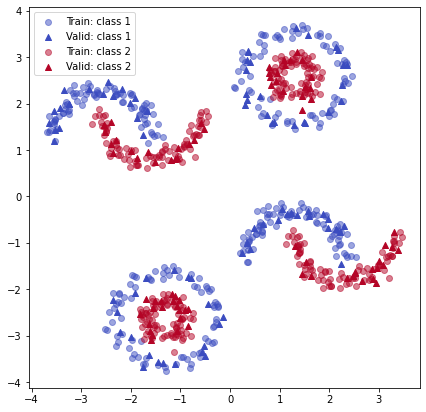

In [7]:
plt.figure(figsize=(7,7))

for i in (0,1): 
    plt.scatter(*Xt[Yt==i].T, color = colors[i], marker='o', alpha=.5, label = f'Train: class {i+1}')
    plt.scatter(*Xv[Yv==i].T, color = colors[i], marker='^', label = f'Valid: class {i+1}')
plt.legend()
plt.show()

## Building the Model 


We will use a simple multi layer perceptron (MLP), which consists of multiple dense (fully connected) hidden layers with `relu` activations and a final output layer that outputs the class probability with a `softmax` activation function (as we only have 2 classes, this is equivalent to a single output and `sigmoid` final activation).   
  

In [8]:
def build_model(activation = "relu", n_neurons=64, n_hidden = 3):
    np.random.seed(42)
    inp = Input((2,), name = "input")
    layer = inp 
    for n in range(n_hidden):
        layer = Dense(n_neurons,activation=activation, name= "hidden_%s"%(n+1))(layer)
        
    out = Dense(2, activation='softmax', name =  "output")(layer)
    return Model(inp, out)

As loss function we use `SparseCategoricalCrossentropy`, as we are dealing with class probabilities in the output. As optimizer we use `Adam`, which is a good general purpose optimizer.

In [9]:
model = build_model()

model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(), optimizer=Adam(learning_rate=0.005))
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 2)]               0         
                                                                 
 hidden_1 (Dense)            (None, 64)                192       
                                                                 
 hidden_2 (Dense)            (None, 64)                4160      
                                                                 
 hidden_3 (Dense)            (None, 64)                4160      
                                                                 
 output (Dense)              (None, 2)                 130       
                                                                 
Total params: 8,642
Trainable params: 8,642
Non-trainable params: 0
_________________________________________________________________


2023-05-15 08:23:11.013425: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-15 08:23:11.114809: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-15 08:23:11.116158: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-05-15 08:23:11.118545: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

Next we define a callback that is used to show the loss value (for training and validation) during the optimization, as well as plots the classification landscape for the model. Just run this cell, no need to understand it :) 

In [10]:
from IPython.display import clear_output
from collections import defaultdict
import tensorflow.keras.backend as K

class MyCallback(Callback):
    def __init__(self, X, Y, Xv, Yv, xlim_test =(-1.5,1.5), n_interval = 5, smooth = .4, yscale = "log"):
        self._n_interval = n_interval
        self._logs = defaultdict(list)
        self._logs_smooth = defaultdict(list)
        self._weights = []
        self._x = np.linspace(*xlim_test,60)
        self._X_test = np.stack(np.meshgrid(self._x,self._x,indexing ='ij'), axis=-1).reshape(-1,2)
        self._X_train = X
        self._Y_train = Y
        self._X_val = Xv
        self._Y_val = Yv
        self._axs = None
        self._yscale = yscale
        self._smooth = smooth
        super(MyCallback,self).__init__()

    def on_epoch_end(self, epoch, logs={}):

        for k,v in logs.items():
            self._logs[k].append(v)
            if epoch==0:
                self._logs_smooth[k].append(v)
            else:
                self._logs_smooth[k].append((1-self._smooth)*v+self._smooth*self._logs_smooth[k][-1])
            
            
        ws = np.concatenate([w.flatten() for w in self.model.get_weights()])
        self._weights.append(ws)
        self.eval_and_plot(epoch) 

    def eval_and_plot(self, epoch=0):
        Y_pred_test  = self.model.predict(self._X_test)
        Y_pred_train = self.model.predict(self._X_train)

        # plot every self._n_interval epoch 
        if (epoch % self._n_interval) ==0:

            _, self.axs = plt.subplots(1, 2, figsize=(12,4))
            self.axs = self.axs.flatten()    

            clear_output(wait=True)

            for i,k in enumerate(self._logs.keys()):
                self.axs[0].plot(np.arange(epoch+1),self._logs[k], color = "C%s"%i, alpha = .2)
                self.axs[0].plot(np.arange(epoch+1),self._logs_smooth[k], color = "C%s"%i,label = k)
                
            self.axs[0].legend()
            self.axs[0].set_yscale(self._yscale)
            
            
            self.axs[1].contourf(self._x, self._x, Y_pred_test[...,1].reshape((len(self._x),len(self._x))).T, 
                                 100, vmin=0, vmax=1, cmap = cmap, alpha=.5)
            
            self.axs[1].scatter(*self._X_train.T, color = colors[self._Y_train], marker='.', alpha=.2)
            self.axs[1].scatter(*self._X_val.T, color = colors[self._Y_val], marker='^', alpha=.6)
            
            self.axs[1].set_ylim(-4,4)                                 
            self.axs[1].set_xlim(-5,5)                                             

            plt.show()
cb = MyCallback(X,Y, Xv, Yv, xlim_test = (-5,5), n_interval = 1)

## Model training/optimization

Now we train the model, i.e. we iterate over random subsets (of size `batch_size`) of the training data, compute the loss function and adjust the model weights according to the gradients. This is repeated for `epoch` number of steps. The callback we have just defined will show you how the training/valdiation loss, as well as the classification boundary of the model change over time. 

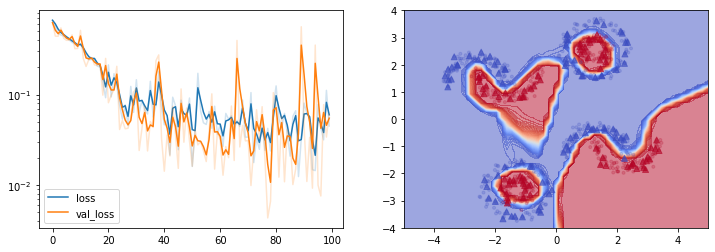

200/200 [==============================] - 2s 9ms/step - loss: 0.0450 - val_loss: 0.0609


In [11]:
model.fit(X, Y, batch_size=4,
          validation_data=(Xv, Yv),
          callbacks=[cb, ReduceLROnPlateau(factor=0.5, patience=10)],
          epochs=100)